In [20]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import datetime, os

import os
from tqdm import tqdm
import cv2
import seaborn as sn
import pandas as pd

In [21]:
label_count = {'Human': 34999, 'Blank': 35000, 'Elephant_African': 34999, 'Hog_Red_River': 26069, 'Buffalo_African': 6459, 'Leopard_African': 2142, 'Monkey': 5038, 'Duiker_Blue': 35000, 'Duiker_Red': 34999, 'Porcupine_Brush_Tailed': 13694, 'Rodent': 1358, 'Squirrel': 11348, 'Rat_Giant': 34225, 'Guineafowl_Crested': 1513, 'Duiker_Yellow_Backed': 15436, 'Guineafowl_Black': 12054, 'Mongoose': 5518, 'Rail_Nkulengu': 3269, 'Chimpanzee': 5260, 'Bird': 6649, 'Genet': 3303, 'Gorilla': 1074, 'Pangolin': 872, 'Mongoose_Black_Footed': 1475, 'Mandrillus': 9305, 'Civet_African_Palm': 936, 'Chevrotain_Water': 4713, 'Cat_Golden': 406}

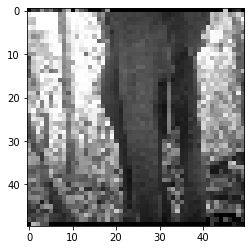

In [22]:
data = np.load("../Data/Data_Gabon/training_data_gabon.npy", allow_pickle=True)
plt.imshow(data[2][0], cmap="gray")
plt.show()

In [4]:
len(data)

347113

In [5]:
35000 // 24

1458

In [23]:
# Normalize pixel values to be between 0 and 1
for pictures in data:
    pictures[0] = pictures[0] / 255

In [24]:
# new_data = []
# for i in data:
#     if i[1] > 18:
#         i[1] = i[1] -1
#     new_data.append(i)

In [38]:
# select 400 pictures of each class.
new_data = []
counter = {}
for i in data:
    if i[1] not in counter.keys():
        counter[i[1]] = 0
        
for picture in data:
    if picture[1] == 0 or picture[1] == 2:
        new_data.append(picture)
        counter[picture[1]] += 1
    elif picture[1] in counter.keys():
        if counter[picture[1]] != 1521:
            counter[picture[1]] += 1
            picture[1] = 1
            new_data.append(picture)
len(new_data)

106531

In [25]:
# check labels
label_count = {}
for items, labels in new_data:
    if labels in label_count:
        label_count[labels] += 1
    else:
        label_count[labels] = 1
print(label_count)

{16: 5518, 18: 5260, 2: 34999, 7: 35000, 3: 26069, 12: 34225, 1: 35000, 14: 15436, 0: 34999, 5: 2142, 15: 12054, 23: 1475, 8: 34999, 26: 4713, 10: 1358, 9: 13694, 25: 936, 24: 9305, 20: 3303, 11: 11348, 17: 3269, 19: 6649, 6: 5038, 13: 1513, 27: 406, 4: 6459, 21: 1074, 22: 872}


In [26]:
# get the labels
def get_labels(data):
    images, labels = [], []
    for items in data:
        images.append(items[0])
        labels.append(items[1])
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

images, labels = get_labels(new_data)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [28]:
# reduce dimentions
X_train = tf.expand_dims(X_train, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)
X_val = tf.expand_dims(X_test, axis=-1)
y_train = tf.expand_dims(y_train, axis=-1)
y_test = tf.expand_dims(y_test, axis=-1)
y_val = tf.expand_dims(y_test, axis=-1)

In [29]:
# creating the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
# model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(len(label_count))) # <---- change ending layers!!!

model.summary()  # summary

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)              

In [30]:
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# With tensorboard
history = model.fit(X_train, y_train, epochs=1, batch_size = 32,
                    validation_data=(X_val, y_val))

# With tensorboard
# history = model.fit(X_train, y_train, epochs=10, batch_size = 32,
#                     validation_data=(X_val, y_val), callbacks=[tensorboard_callback])

6509/6509 [==============================] - 213s 33ms/step - loss: 1.7580 - accuracy: 0.4490 - val_loss: 1.4995 - val_accuracy: 0.5217


In [31]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(test_acc)

2170/2170 [==============================] - 16s 8ms/step - loss: 1.4995 - accuracy: 0.5217
0.5216571092605591


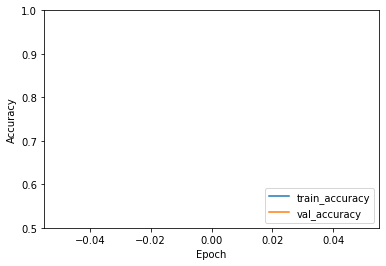

In [32]:
# launch tensorboard
# %tensorboard --logdir logs --host localhost
# %tensorboard --logdir logs 

# plot results
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


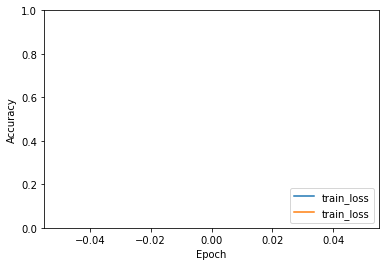

In [33]:
# plot results
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [34]:
# score per class
Y_test = tf.reshape(y_test, [len(y_test)])
# Y_test = np.argmax(y_pred, axis=1) # Convert one-hot to index
# y_pred = model.predict_classes()
y_pred = np.argmax(model.predict(X_test), axis=-1)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.76      0.64      6998
           1       0.72      0.69      0.71      6960
           2       0.59      0.49      0.53      7091
           3       0.59      0.46      0.52      5017
           4       0.74      0.52      0.62      1275
           5       0.00      0.00      0.00       432
           6       0.14      0.01      0.02       971
           7       0.34      0.60      0.44      7147
           8       0.35      0.47      0.40      6987
           9       0.62      0.20      0.30      2769
          10       0.28      0.13      0.18       266
          11       0.27      0.06      0.10      2293
          12       0.62      0.91      0.74      6881
          13       0.69      0.07      0.12       307
          14       0.58      0.69      0.63      3042
          15       0.75      0.49      0.60      2402
          16       0.00      0.00      0.00      1120
          17       0.00    

C:\Users\Siebren\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<ipython-input-37-721a636f1613>:7: RuntimeWarning: invalid value encountered in true_divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized


<AxesSubplot:>

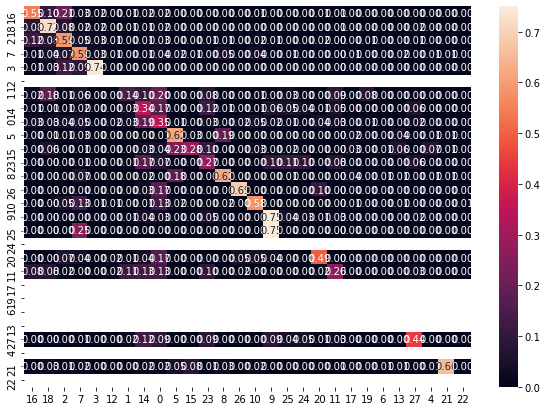

In [37]:
y_pred = model.predict(X_test)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for y in y_test], axis=0)
cm = confusion_matrix(predicted_categories, true_categories)

# cmn = cm
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized

class_names = label_count.keys()

df_cm = pd.DataFrame(cmn, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.2f')

In [56]:
# model.save('Models/model_V3.h5')

In [57]:
# # Convert the model.
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model.
# with open('Models/model.tflite', 'wb') as f:
#     f.write(tflite_model)

# Test on myanmar data

2


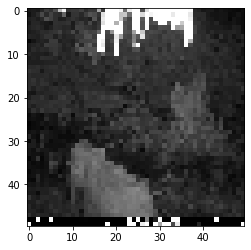

In [126]:
myanmar_data = np.load("../Data/Data_Myanmar/testing_data_myanmar_for_gabon_model.npy", allow_pickle=True)
i = 6
plt.imshow(myanmar_data[i][0], cmap="gray")
print(myanmar_data[i][1])
plt.show()

In [127]:
pictures_myan = []
labels_myan = []

# Normalize pixel values to be between 0 and 1
for pic in myanmar_data:
    pic[0] = pic[0] / 255

# batch_count = {}
# # create batch
# for picture_myan, label_myan in myanmar_data:
#     if label_myan in batch_count.keys():
#         if batch_count[label_myan] < 90:
#             pictures_myan.append(picture_myan)
#             labels_myan.append(label_myan)
#             batch_count[label_myan] += 1
#     else:
#         batch_count[label_myan] = 1
#         pictures_myan.append(picture_myan)
#         labels_myan.append(label_myan)


# get all
for picture_myan, label_myan in myanmar_data:
    pictures_myan.append(picture_myan)
    labels_myan.append(label_myan)
 

In [128]:
pictures_myan = np.array(pictures_myan)
labels_myan = np.array(labels_myan)

pictures_myan = tf.expand_dims(pictures_myan, axis=-1)
labels_myan = tf.expand_dims(labels_myan, axis=-1)

In [129]:
test_loss, test_acc = model.evaluate(pictures_myan, labels_myan, verbose=1)
print(test_acc)

92/92 [==============================] - 1s 6ms/step - loss: 1.4106 - accuracy: 0.3938
0.39378416538238525


In [130]:
# score per class
Y_test = tf.reshape(labels_myan, [len(labels_myan)])
# Y_test = np.argmax(y_pred, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(pictures_myan)
# np.argmax(model.predict(pictures_myan), axis=-1)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.43      0.56      2562
           1       0.04      0.14      0.06       274
           2       0.02      0.14      0.04        92

    accuracy                           0.39      2928
   macro avg       0.29      0.24      0.22      2928
weighted avg       0.72      0.39      0.50      2928



In [131]:
predictions = model.predict(pictures_myan)

In [132]:
correct_zero, correct_one, correct_two = 0, 0, 0
for i in range(len(predictions)):
    if Y_test[i].numpy() != predictions[i].argmax():
        print("correct: " + str(Y_test[i].numpy()) + " pred: " + str(predictions[i].argmax()))
        print("---------------------")
    else:
        if Y_test[i].numpy() == 0:
            correct_zero += 1
        elif Y_test[i].numpy() == 1:
            correct_one += 1
        elif Y_test[i].numpy() == 2:
            correct_two += 1

correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 2 pred: 0
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred:

correct: 2 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred:

correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 1 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 2 pred: 0
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred:

correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred:

In [133]:
count_zero, count_one, count_two = 0, 0, 0
for label in labels_myan:
    if label == 0:
        count_zero += 1
    elif label == 1:
        count_one += 1
    elif label == 2:
        count_two += 1
print("Human " + str(count_zero) + " / " + str(correct_zero))
print("Other " + str(count_one) + " / " + str(correct_one))
print("Elephant " + str(count_two) + " / " + str(correct_two))

Human 2562 / 1101
Other 274 / 39
Elephant 92 / 13


<AxesSubplot:>

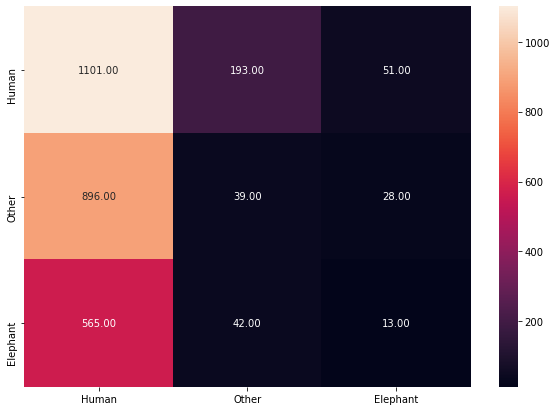

In [134]:
y_pred = model.predict(pictures_myan)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for y in labels_myan], axis=0)
cm = confusion_matrix(predicted_categories, true_categories)

cmn = cm # <- cant normalize because of devided by 0
# cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized

class_names = ["Human", "Other", "Elephant"]

df_cm = pd.DataFrame(cmn, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.2f')